<a href="https://colab.research.google.com/github/gyanendrasingh583/Amzon-Product-Recommendation/blob/master/Power_system_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import tensorflow as tf

from keras import optimizers
from keras import regularizers

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, add, Dropout, Lambda, LSTM
from keras.layers import Input, average, TimeDistributed, SimpleRNN, LeakyReLU
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

In [ ]:
def huber_loss(y_true, y_pred, clip_delta=0.010):
    error = y_true - y_pred
    cond  = K.abs(error) < clip_delta

    squared_loss = 0.5 * K.square(error)
    linear_loss  = 0* clip_delta * (K.abs(error) - 0 * clip_delta)

    return tf.where(cond, linear_loss, squared_loss)

def huber_loss_mean(y_true, y_pred):
    return K.mean(huber_loss(y_true, y_pred))

def st_activation(tensor, th = 0.2):
    '''Performs the soft thresholding operation'''
    cond  = K.abs(tensor) < th
    st_tensor = tensor - th*K.sign(tensor)
    return  tf.where(cond, tf.zeros(tf.shape(tensor)), st_tensor)


def ANN_fase(input_shape, output_shape, weights = None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector
    input_shape = input_shape[1:]
    data = Input(shape=input_shape, dtype='float', name='data')
    dense1 = Dense(units = 236, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    predictions = Dense(units = output_shape, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense1)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)

    model.compile(optimizer=sgd, loss='mae',
                  metrics=['mae'])
    return model


def rnn_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector
    model = Sequential()
    #Since we know the shape of our Data we can input the timestep and feature data
    #The number of timestep sequence are dealt with in the fit function
    model.add(SimpleRNN(input_shape[2], input_shape=(input_shape[1], input_shape[2])))
    #model.add(Dropout(0.2))
    #number of features on the output
    model.add(Dense(output_shape, activation='linear',   use_bias=True, kernel_regularizer=None))
    if weights is not None:
        model.load_weights(weights)
    sgd =tf.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='mean_squared_error',
                      metrics=['mae'])
    return model



def lstm_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector
    model = Sequential()
    #Since we know the shape of our Data we can input the timestep and feature data
    #The number of timestep sequence are dealt with in the fit function
    model.add(LSTM( input_shape[2], input_shape=(input_shape[1], input_shape[2])))
    #model.add(Dropout(0.2))
    #number of features on the output
    model.add(Dense(output_shape, activation='linear', use_bias=True))
    sgd = tf.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='mean_squared_error',
                      metrics=['mae'])
    return model


def lstm_dinput_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector
    model = Sequential()
    #Since we know the shape of our Data we can input the timestep and feature data
    #The number of timestep sequence are dealt with in the fit function
    model.add(TimeDistributed(Dense(256), input_shape=(input_shape[1], input_shape[2])))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    #number of features on the output
    model.add(Dense(output_shape, activation='linear'))
    sgd = tf.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss='mean_squared_error',
                      metrics=['mae'])
    return model


def stack_rnn_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector

    model = Sequential()
    #Since we know the shape of our Data we can input the timestep and feature data
    #The number of timestep sequence are dealt with in the fit function
    model.add(SimpleRNN(input_shape[2], activation='relu',  return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    #model.add(Dropout(0.2))
    #number of features on the output
    model.add(SimpleRNN(input_shape[2], activation='relu',  return_sequences=True))
    #model.add(SimpleRNN(input_shape[2], return_sequences=True))
    model.add(SimpleRNN(input_shape[2], activation='relu', ))
    model.add(Dense(output_shape, activation='linear',  use_bias=True, kernel_regularizer=None))
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss= 'mae',
                      metrics=['mae'])
    return model



def rnn_plnet_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector

    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float', name='data')

    #Define a plnet
    data = Input(shape=input_shape[2:], dtype='float', name='data')
    merged1 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    u01 = Activation('relu')(merged1)
    dense1 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u01)
    add1 = add([merged1, dense1])
    u02 = Activation('relu')(add1)
    dense2 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u02)
    add2 = add([merged1, dense2])
    u03 = Activation('relu')(add2)


    dense3 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u03)
    dense4 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(data)
    merged2 = add([dense3, dense4])

    u11 = Activation('relu')(merged2)
    dense5 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u11)
    add3 = add([merged2, dense5])
    u12 = Activation('relu')(add3)
    dense6 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u12)
    add4 = add([merged2, dense6])
    u13 =  Activation('relu')(add4)

    dense_o1 = Dense(units = input_shape[2], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(data)
    add_o1 = add([u13, dense_o1])


    #predictions = Dense(units = output_shape, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(add_o1)

    plnet = Model(inputs=data, outputs=add_o1)
    out = TimeDistributed(plnet)(inputs)

    
    rnn1 = SimpleRNN(input_shape[2],  activation='relu', return_sequences=True)(out)
    rnn2 = SimpleRNN(input_shape[2],  activation='relu', return_sequences=True)(rnn1)
    rnn3 = SimpleRNN(input_shape[2],  activation='relu', return_sequences=False)(rnn2)

    new_v = Dense(output_shape, activation='linear')(rnn3)

    model = Model(inputs=inputs, outputs=new_v)
    if weights is not None:
        model.load_weights(weights)
    sgd = optimizers.adam(lr=0.001)

    model.compile(optimizer=sgd, loss = 'mae',
                  metrics=['mae'])

    return model

def pretrained_rnn_plnet_fase(input_shape, output_shape, weights = None, pl_weights = None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector

    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float', name='data')

    #Define a plnet
    learnable = False
    data = Input(shape=input_shape[2:], dtype='float', name='data')
    merged1 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    u01 = Activation('relu')(merged1)
    dense1 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(u01)
    add1 = add([merged1, dense1])
    u02 = Activation('relu')(add1)
    dense2 = Dense(units = input_shape[2], activation=None, use_bias=True,  trainable = learnable, kernel_initializer='glorot_uniform')(u02)
    add2 = add([merged1, dense2])
    u03 = Activation('relu')(add2)


    dense3 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(u03)
    dense4 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(data)
    merged2 = add([dense3, dense4])

    u11 = Activation('relu')(merged2)
    dense5 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(u11)
    add3 = add([merged2, dense5])
    u12 = Activation('relu')(add3)
    dense6 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(u12)
    add4 = add([merged2, dense6])
    u13 =  Activation('relu')(add4)

    dense_o1 = Dense(units = input_shape[2], activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform')(data)
    add_o1 = add([u13, dense_o1])


    predictions = Dense(units = output_shape, activation=None, use_bias=True, trainable = learnable, kernel_initializer='glorot_uniform', bias_initializer='zeros')(add_o1)

    plnet = Model(inputs=data, outputs=predictions)
    if pl_weights is not None:
        plnet.load_weights(pl_weights)


    out = TimeDistributed(plnet)(inputs)


    rnn1 = SimpleRNN(input_shape[2],   activation='relu' ,return_sequences=True)(out)
    rnn2 = SimpleRNN(input_shape[2],   activation='relu' , return_sequences=True)(rnn1)
    rnn3 = SimpleRNN(input_shape[2],  activation='relu',  return_sequences=False)(rnn2)

    new_v = Dense(output_shape, activation='linear')(rnn3)

    model = Model(inputs=inputs, outputs=new_v)
    if weights is not None:
        model.load_weights(weights)
    sgd = optimizers.adam(lr=0.001)

    model.compile(optimizer=sgd, loss = 'mae',
                  metrics=['mae'])

    return model

def simplified_rpln_fase(input_shape, output_shape, weights=None):
    # input_shape (batch_size, time_series, input_dim)
    # out_shape: dimension of the voltage vector

    model = Sequential()
    #Since we know the shape of our Data we can input the timestep and feature data
    #The number of timestep sequence are dealt with in the fit function
    model.add(SimpleRNN(input_shape[2], return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    #model.add(Dropout(0.2))
    #number of features on the output
    model.add(SimpleRNN(input_shape[2], return_sequences=True))
    #model.add(SimpleRNN(input_shape[2], return_sequences=True))
    model.add(SimpleRNN(input_shape[2]))
    model.add(Dense(output_shape, activation='linear',  use_bias=True, kernel_regularizer=None))
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)
    model.compile(optimizer=sgd, loss= 'mean_squared_error',
                      metrics=['mae'])
    return model


def lav_psse(input_shape, num_classes, weights=None):
    '''
    :param input_shape:
    :param num_classes:
    :param weights:
    :return: 6 hidden layer NN model with specified training loss
    '''
    data = Input(shape=input_shape, dtype='float', name='data')
    merged1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    u01 = Activation('relu')(merged1)
    dense1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u01)
    add1 = add([merged1, dense1])
    u02 = Activation('relu')(add1)
    dense2 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u02)
    add2 = add([merged1, dense2])
    u03 = Activation('relu')(add2)

    dense3 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u03)
    dense4 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(data)
    merged2 = add([dense3, dense4])
    u11 = Activation('relu')(merged2)
    dense5 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u11)
    add3 = add([merged2, dense5])
    u12 = Activation('relu')(add3)
    dense6 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u12)
    add4 = add([merged2, dense6])
    u13 =  Activation('relu')(add4)


#    u13 =  Dropout(rate=0.5, name='drop_u23')(u13)
    dense_o1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(data)
    add_o1 = add([u13, dense_o1])
#   drop_o1 = Dropout(rate=0.5, name='drop1')(add_o1)

    predictions = Dense(units = num_classes, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(add_o1)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)

    model.compile(optimizer=sgd, loss=huber_loss_mean,
                  metrics=['mae'])

    return model

def nn0_psse(input_shape, num_classes, weights=None):
    '''
    :param input_shape:
    :param num_classes:
    :param weights:
    :return: 1 hidden layer NN model with specified training loss
    '''
    data = Input(shape=input_shape, dtype='float', name='data')
    dense1 = Dense(units = input_shape[0], activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    dense2 = Dense(units = input_shape[0], activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense1)
    dense3 = Dense(units = input_shape[0], activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense2)

    predictions = Dense(units = num_classes, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense3)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
#    sgd = optimizers.adam(lr=0.0001)

    sgd = tf.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

    model.compile(optimizer=sgd, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def nn1_psse(input_shape, num_classes, weights=None):
    '''
    :param input_shape:
    :param num_classes:
    :param weights: 6 layers
    :return: 1 hidden layer NN model with specified training loss
    '''
    data = Input(shape=input_shape, dtype='float', name='data')
    dense1 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    dense2 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense1)
    dense3 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense2)
    dense4 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense3)
    dense5 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense4)

    dense6 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense5)
#    dense7 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense6)
#    dense8 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense7)
#    dense9 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense8)
#    dense10 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense9)

#    drop1 = Dropout(rate=0.5, name='drop1')(dense8)
    predictions = Dense(units = num_classes, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense6)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)

#    sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

    model.compile(optimizer=sgd, loss=huber_loss_mean,
                  metrics=['mae'])

    return model




def nn1_8H_psse(input_shape, num_classes, weights=None):
    '''
    :param input_shape:
    :param num_classes:
    :param weights: 6 layers
    :return: 1 hidden layer NN model with specified training loss
    '''
    data = Input(shape=input_shape, dtype='float', name='data')
    dense1 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    dense2 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense1)
    dense3 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense2)
    dense4 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense3)
    dense5 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense4)

    dense6 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense5)
    dense7 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense6)
    dense8 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense7)
#    dense9 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense8)
#    dense10 = Dense(units = input_shape[0], activation='relu',  use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense9)

#    drop1 = Dropout(rate=0.5, name='drop1')(dense8)
    predictions = Dense(units = num_classes, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(dense8)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = tf.optimizers.Adam(lr=0.001)

#    sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

    model.compile(optimizer=sgd, loss=huber_loss_mean,
                  metrics=['mae'])

    return model






In [ ]:
def st_lav_psse(input_shape, num_classes, weights=None):
    '''
    soft_max activation
    :param input_shape:
    :param num_classes:
    :param weights:
    :return: estimated voltages
    '''
    data = Input(shape=input_shape, dtype='float', name='data')
    merged1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(data)
    u01 = Lambda(st_activation, name='st0')(merged1)
    dense1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u01)
    add1 = add([merged1, dense1])
    u02 = Lambda(st_activation, name='st1')(add1)
    dense2 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(u02)
    add2 = add([merged1, dense2])
    u03 = Lambda(st_activation, name='st2')(add2)
    dense_o1 = Dense(units = input_shape[0], activation=None, use_bias=True, kernel_initializer='glorot_uniform')(data)
    add_o1 = add([u03, dense_o1])
    predictions = Dense(units = num_classes, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(add_o1)

    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = optimizers.adam(lr=0.001)

    model.compile(optimizer=sgd, loss=huber_loss_mean,
                  metrics=['mae'])
    return model


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

SEED=1234
import numpy as np
import math
from matplotlib import pyplot as plt
np.random.seed(SEED)
import keras
from keras import backend as K
import tensorflow as tf
import os, shutil, scipy.io
#from model import *

In [ ]:
# data loading part
caseNo = 118
weight_4_mag = 100
weight_4_ang = 1#2*math.pi/360


psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
print(psse_data['inputs'].shape, psse_data['labels'].shape)
psse_data['inputs'][0].shape

data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]


# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape, val_x.shape)
#Train the model
train_x
print(train_y.shape, val_y.shape, test_y.shape)

(490, 18528) (236, 18528)
(14822, 490) (3706, 490)
(14822, 236) (3706, 236) (0, 236)


In [ ]:
from keras.optimizers import Adam

**lstm_fase**

In [ ]:
tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
#K.set_learning_phase(1)
#tf.compat.v1.Keras.backend.set_session(tf.compat.v1.Session(config=config))
K.set_learning_phase(1)

# data loading part
 
caseNo = 118
input_dim = caseNo * 2
weight_4_mag = 100.0
weight_4_ang = 1.0#2*math.pi/360

# data loading part
psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]
# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])


total_v = len(train_y)
print(train_y.shape, val_y.shape, val_y[0].shape)
#How many timesteps e.g how many characters we want to process in one go
time_steps = 10

#Since our timestep sequence represetns a process for every 100 chars we omit
#the first 100 chars so the loop runs a 100 less or there will be index out of
#range
counter = total_v - time_steps

#Inpput data
vX = []
#output data
y = []
#This loops through all the characters in the data skipping the first 100
for i in range(counter):
    #This one goes from 0-100 so it gets 100 values starting from 0 and stops
    #just before the 100th value
    theInput = train_y[i:i+time_steps]
    #With no : you start with 0, and so you get the actual 100th value
    #Essentially, the output Chars is the next char in line for those 100 chars
    #in X
    theOutput = train_y[i + time_steps]
    #Appends every 100 chars ids as a list into X
    vX.append(theInput)
    #For every 100 values there is one y value which is the output
    y.append(theOutput)

#Len charX represents how many of those time steps we have
#Our features are set to 1 because in the output we are only predicting 1 char
#Finally numberOfCharsToLearn is how many character we process
X = np.reshape(vX, (len(vX), time_steps, input_dim))
y = np.reshape(y, (len(y), len(y[0])))

rnnFaseModel = lstm_fase(X.shape, y.shape[1], weights=None)

rnnFaseModel.fit(X, y, epochs = 200, batch_size=32)
rnnFaseModel.save_weights("lstm_fase.hdf5")
#model.load_weights("LSTMforStatePredic.hdf5")

#this is for forecasting the new voltage profile
K.set_learning_phase(0)
ans = [] # ans collects the result of all the voltages
test_no = 3706
v_start = vX[-1]
for i in range(test_no):
    x = np.reshape(v_start, (1, time_steps, input_dim))
    pred = rnnFaseModel.predict(x)
    ans.append(pred)
    true_v = np.reshape(val_y[i], pred.shape)
    v_start = np.concatenate((v_start, true_v), axis = 0)
    v_start = v_start[1:]


voltage_distance = np.zeros((test_no,caseNo))
voltage_norm = np.zeros((test_no,1))
val_predic = np.reshape(ans, (test_no, input_dim))


for i in range(test_no):
    for j in range(caseNo):
        predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
        val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
        voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
        #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
    voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
print("\n distance from the true states in terms of \|\|_2: %.4f%%" % (np.mean(voltage_norm)*100))
print(voltage_norm)
print(np.amin(voltage_norm), np.argmin(voltage_norm))




/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(14822, 236) (3706, 236) (236,)
Epoch 1/200
463/463 [==============================] - 3s 4ms/step - loss: 5779.4667 - mae: 72.9819
Epoch 2/200
463/463 [==============================] - 2s 4ms/step - loss: 2239.9032 - mae: 43.3558
Epoch 3/200
463/463 [==============================] - 2s 4ms/step - loss: 713.0976 - mae: 23.1507
Epoch 4/200
463/463 [==============================] - 2s 4ms/step - loss: 190.3914 - mae: 12.0795
Epoch 5/200
463/463 [==============================] - 2s 4ms/step - loss: 57.9764 - mae: 6.5320
Epoch 6/200
463/463 [==============================] - 2s 4ms/step - loss: 38.1969 - mae: 4.2715
Epoch 7/200
463/463 [==============================] - 2s 4ms/step - loss: 35.0902 - mae: 3.4296
Epoch 8/200
463/463 [==============================] - 2s 4ms/step - loss: 35.8019 - mae: 3.2940
Epoch 9/200
463/463 [==============================] - 2s 4ms/step - loss: 34.8662 - mae: 3.2220
Epoch 10/200
463/463 [==============================] - 2s 4ms/step - loss: 34.5674 -

(236,)
(3706, 236)


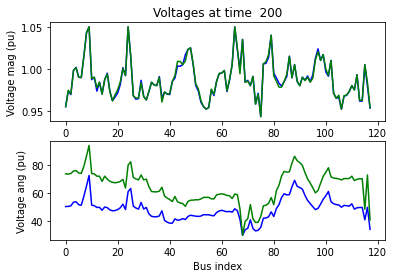

In [ ]:
 #add the plot here

timeslot = 200
points = caseNo

print(val_y[timeslot].shape)
print(val_predic.shape)

plt.subplot(2,1,1)
plt.plot(range(points), (1/weight_4_mag)*val_y[timeslot][0:points], color='b')
#plt.hold
plt.plot(range(points), (1/weight_4_mag)*val_predic[timeslot][0:points], color='g')
plt.ylabel('Voltage mag (pu)')
plt.title('Voltages at time  ' + str(timeslot))

plt.subplot(2,1,2)
plt.plot(range(points), val_y[timeslot][caseNo:caseNo+points], color='b')
#plt.hold
plt.plot(range(points), val_predic[timeslot][caseNo:caseNo+points], color='g')
plt.ylabel('Voltage ang (pu)')
plt.xlabel('Bus index')

plt.show()



**Simplified RNN**

In [ ]:
tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
#K.set_learning_phase(1)
#tf.compat.v1.Keras.backend.set_session(tf.compat.v1.Session(config=config))
K.set_learning_phase(1)

# data loading part
 
caseNo = 118
input_dim = caseNo * 2
weight_4_mag = 100.0
weight_4_ang = 1.0#2*math.pi/360

# data loading part
psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]
# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])


total_v = len(train_y)
print(train_y.shape, val_y.shape, val_y[0].shape)
#How many timesteps e.g how many characters we want to process in one go
time_steps = 10

#Since our timestep sequence represetns a process for every 100 chars we omit
#the first 100 chars so the loop runs a 100 less or there will be index out of
#range
counter = total_v - time_steps

#Inpput data
vX = []
#output data
y = []
#This loops through all the characters in the data skipping the first 100
for i in range(counter):
    #This one goes from 0-100 so it gets 100 values starting from 0 and stops
    #just before the 100th value
    theInput = train_y[i:i+time_steps]
    #With no : you start with 0, and so you get the actual 100th value
    #Essentially, the output Chars is the next char in line for those 100 chars
    #in X
    theOutput = train_y[i + time_steps]
    #Appends every 100 chars ids as a list into X
    vX.append(theInput)
    #For every 100 values there is one y value which is the output
    y.append(theOutput)

#Len charX represents how many of those time steps we have
#Our features are set to 1 because in the output we are only predicting 1 char
#Finally numberOfCharsToLearn is how many character we process
X = np.reshape(vX, (len(vX), time_steps, input_dim))
y = np.reshape(y, (len(y), len(y[0])))

rnnFaseModel =  simplified_rpln_fase(X.shape, y.shape[1], weights=None)

rnnFaseModel.fit(X, y, epochs = 40, batch_size=32)
rnnFaseModel.save_weights("/content/drive/My Drive/power_system/SimplifiedRNN.hdf5")
#model.load_weights("LSTMforStatePredic.hdf5")

#this is for forecasting the new voltage profile
K.set_learning_phase(0)
ans = [] # ans collects the result of all the voltages
test_no = 3706
v_start = vX[-1]
for i in range(test_no):
    x = np.reshape(v_start, (1, time_steps, input_dim))
    pred = rnnFaseModel.predict(x)
    ans.append(pred)
    true_v = np.reshape(val_y[i], pred.shape)
    v_start = np.concatenate((v_start, true_v), axis = 0)
    v_start = v_start[1:]


voltage_distance = np.zeros((test_no,caseNo))
voltage_norm = np.zeros((test_no,1))
val_predic = np.reshape(ans, (test_no, input_dim))


for i in range(test_no):
    for j in range(caseNo):
        predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
        val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
        voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
        #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
    voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
print("\n distance from the true states in terms of \|\|_2: %.4f%%" % (np.mean(voltage_norm)*100))
print(voltage_norm)
print(np.amin(voltage_norm), np.argmin(voltage_norm))



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(14822, 236) (3706, 236) (236,)
Epoch 1/40
463/463 [==============================] - 11s 21ms/step - loss: 4025.5392 - mae: 57.7953
Epoch 2/40
463/463 [==============================] - 10s 21ms/step - loss: 135.3491 - mae: 9.8284
Epoch 3/40
463/463 [==============================] - 10s 21ms/step - loss: 35.0701 - mae: 3.5476
Epoch 4/40
463/463 [==============================] - 10s 21ms/step - loss: 35.0420 - mae: 3.2461
Epoch 5/40
463/463 [==============================] - 10s 21ms/step - loss: 34.3883 - mae: 3.2082
Epoch 6/40
463/463 [==============================] - 10s 21ms/step - loss: 35.9331 - mae: 3.2834
Epoch 7/40
463/463 [==============================] - 10s 21ms/step - loss: 34.9959 - mae: 3.2345
Epoch 8/40
463/463 [==============================] - 10s 21ms/step - loss: 35.8265 - mae: 3.2748
Epoch 9/40
463/463 [==============================] - 10s 21ms/step - loss: 34.9174 - mae: 3.2218
Epoch 10/40
463/463 [==============================] - 10s 21ms/step - loss: 34.56

(236,)
(3706, 236)


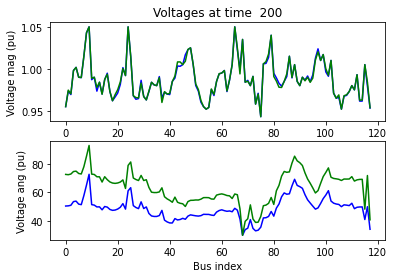

In [ ]:
#add the plot here

timeslot = 200
points = caseNo

print(val_y[timeslot].shape)
print(val_predic.shape)

plt.subplot(2,1,1)
plt.plot(range(points), (1/weight_4_mag)*val_y[timeslot][0:points], color='b')
#plt.hold
plt.plot(range(points), (1/weight_4_mag)*val_predic[timeslot][0:points], color='g')
plt.ylabel('Voltage mag (pu)')
plt.title('Voltages at time  ' + str(timeslot))

plt.subplot(2,1,2)
plt.plot(range(points), val_y[timeslot][caseNo:caseNo+points], color='b')
#plt.hold
plt.plot(range(points), val_predic[timeslot][caseNo:caseNo+points], color='g')
plt.ylabel('Voltage ang (pu)')
plt.xlabel('Bus index')

plt.show()



**nn8_psse_8layer**

In [ ]:
tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
#K.set_learning_phase(1)
#tf.compat.v1.Keras.backend.set_session(tf.compat.v1.Session(config=config))
K.set_learning_phase(1)

# data loading part
 


caseNo = 118
weight_4_mag = 100
weight_4_ang = 1#2*math.pi/360

psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
print(psse_data['inputs'].shape, psse_data['labels'].shape)

data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]


# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape, val_x.shape)
#Train the model
input_shape = (train_x.shape[1],)

epoch_num = 200
psse_model = nn1_8H_psse(input_shape, train_y.shape[1])
psse_model.fit(train_x, train_y, epochs=epoch_num, batch_size=64)
psse_model.save_weights("/content/drive/My Drive/power_system/nn1_8H_psse.h5")

# evaluate the model
K.set_learning_phase(0)
val_predic = psse_model.predict(val_x)
scores = psse_model.evaluate(val_x, val_y)
print("\n%s: %.2f%%" % (psse_model.metrics_names[1], scores[1]*100))


#the self.defined distance metric since, to access the distance between predicted and the true
print(val_y.shape[0])
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100
print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(val_predic, val_y))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(490, 18528) (236, 18528)
(14822, 490) (3706, 490)
Epoch 1/200
232/232 [==============================] - 1s 3ms/step - loss: 394.6640 - mae: 15.0347
Epoch 2/200
232/232 [==============================] - 1s 3ms/step - loss: 0.3841 - mae: 0.5986
Epoch 3/200
232/232 [==============================] - 1s 3ms/step - loss: 0.4199 - mae: 0.6186
Epoch 4/200
232/232 [==============================] - 1s 3ms/step - loss: 0.6127 - mae: 0.8002
Epoch 5/200
232/232 [==============================] - 1s 3ms/step - loss: 1.5578 - mae: 1.2278
Epoch 6/200
232/232 [==============================] - 1s 3ms/step - loss: 0.8032 - mae: 0.8375
Epoch 7/200
232/232 [==============================] - 1s 3ms/step - loss: 1.0176 - mae: 1.0939
Epoch 8/200
232/232 [==============================] - 1s 3ms/step - loss: 2.9148 - mae: 1.7926
Epoch 9/200
232/232 [==============================] - 1s 3ms/step - loss: 1.6908 - mae: 1.1386
Epoch 10/200
232/232 [==============================] - 1s 3ms/step - loss: 0.8595

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from keras import optimizers
from keras import regularizers

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, add, Dropout, Lambda, LSTM
from keras.layers import Input, average, TimeDistributed, SimpleRNN, LeakyReLU
from keras import backend as K
from keras.layers.normalization import BatchNormalization



import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import optimizers
from keras.utils import np_utils
import os, shutil, scipy.io
from matplotlib import pyplot as plt
SEED=1234
import numpy as np
import math
from matplotlib import pyplot as plt
np.random.seed(SEED)
import keras
from keras import backend as K
import tensorflow as tf
import os, shutil, scipy.io
import inspect
from keras.optimizers import Adam
import time

(3706, 236)
(14822, 490)
(3706, 490)
--- 2.5924742221832275 seconds ---

 distance from the true states in terms of \|\|_2: 0.0856%


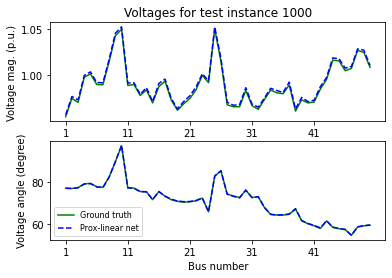

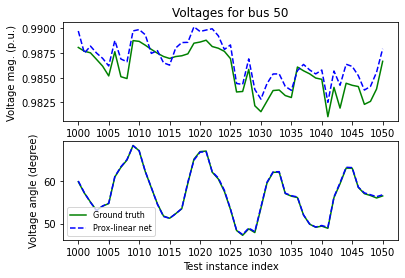

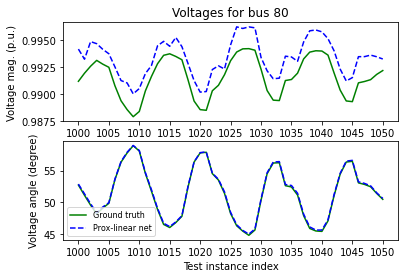

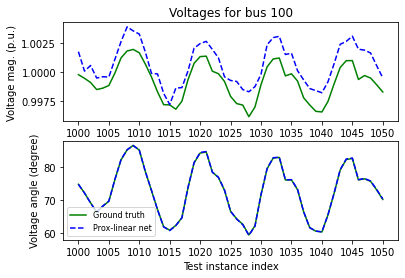

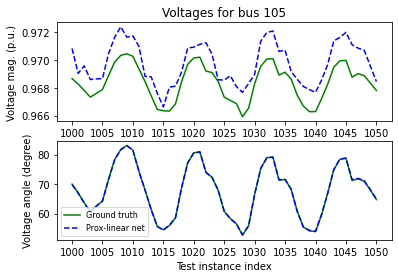

In [ ]:
# data loading part
psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
matlab_predicts = scipy.io.loadmat('/content/drive/My Drive/power_system/118_bus_GStest_err.mat')
gs_predicts = matlab_predicts['GS_voltage']
gs_predicts = np.transpose(gs_predicts)
print(gs_predicts.shape)
data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]
# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape)
print(val_x.shape)

#Train the model
input_shape = (train_x.shape[1],)

start_time = time.time()
lav_weights = '/content/drive/My Drive/power_system/nn1_8H_psse.h5'


lav_model =   nn1_8H_psse(input_shape, train_y.shape[1], weights=lav_weights)
# nn1_6H_model =  nn1_psse(input_shape, train_y.shape[1], weights=nn1_6H_weights)
# nn1_8H_model =  nn1_8H_psse(input_shape, train_y.shape[1], weights=nn1_8H_weights)

#train_lav_predicts = lav_model.predict(train_x)
lav_predicts = lav_model.predict(val_x)
# NN6H_predicts = nn1_6H_model.predict(val_x)
# NN8H_predicts = nn1_8H_model.predict(val_x)

print("--- %s seconds ---" % (time.time() - start_time))
val_predic = lav_predicts
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100

print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(lav_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN6H_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN8H_predicts, val_y))

fig_num = 0
plt.figure(fig_num)
fig_num += 1

busNo = caseNo
start_bus, end_bus = 0, 50
timeslot = 999
plt.subplot(2,1,1)
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* val_y[timeslot][start_bus: end_bus], color='g') # here we have start_bus+1 is due to that in our paper, index starts 1 while python starts 0
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* lav_predicts[timeslot][start_bus: end_bus], linestyle= '--',  color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN6H_predicts[timeslot][start_bus: end_bus],linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN8H_predicts[timeslot][start_bus: end_bus] , color='b')
linestyle= '-.'
plt.ylabel('Voltage mag. (p.u.)')
plt.title('Voltages for test instance ' + str(timeslot+1))
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))

plt.subplot(2,1,2)
plt.plot(range(start_bus+1, end_bus+1), val_y[timeslot][start_bus+ busNo: end_bus+ busNo], color='g')
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), lav_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '--', color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN6H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN8H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], color='b')
plt.ylabel('Voltage angle (degree)')
plt.xlabel('Bus number')
plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
# plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))


def plt_bus(busShow = 100, x_step = 5, start = 999, end = 1050, fig_num = 0):
    plt.figure(fig_num)
# this is for a certain bus across different time slots
    ax1 = plt.subplot(2,1,1)
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* val_y[start: end, busShow], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* lav_predicts[start: end, busShow], linestyle= '--',  color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN6H_predicts[start: end, busShow], linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN8H_predicts[start: end, busShow], color='b')
    #plt.hold
    #plt.plot(range(start+1, end+1), gs_predicts[start: end, busShow], color='c',linestyle= ':')

    ax1.set_xticks(list(range(start+1, end+1, x_step)))
    plt.ylabel('Voltage mag. (p.u.)')
    plt.title('Voltages for bus ' + str(busShow))

    plt.subplot(2,1,2)
    plt.plot(range(start+1, end+1), val_y[start: end, busShow + busNo], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), lav_predicts[start: end, busShow + busNo], linestyle= '--', color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), NN6H_predicts[start: end, busShow + busNo],  linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), NN8H_predicts[start: end, busShow + busNo], color='b')
    plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
    # plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})

    #plt.hold
    #plt.plot(range(start+1, end+1),  gs_predicts[start: end, busShow+ busNo], color='c',linestyle= ':')

    plt.ylabel('Voltage angle (degree)')
    plt.xlabel('Test instance index')
    axes = plt.gca()
    axes.set_xticks(list(range(start+1, end+1, x_step)))

bus_list = [50, 80, 100, 105]
for i, busShow in enumerate(bus_list):
    plt_bus(busShow = busShow, fig_num = i + 1)
plt.show()

**NN1_psse_one layer**

In [ ]:
tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
#K.set_learning_phase(1)
#tf.compat.v1.Keras.backend.set_session(tf.compat.v1.Session(config=config))
K.set_learning_phase(1)

# data loading part
 


caseNo = 118
weight_4_mag = 100
weight_4_ang = 1#2*math.pi/360

psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
print(psse_data['inputs'].shape, psse_data['labels'].shape)

data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]


# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape, val_x.shape)
#Train the model
input_shape = (train_x.shape[1],)

epoch_num = 200
psse_model = nn1_psse(input_shape, train_y.shape[1])
psse_model.fit(train_x, train_y, epochs=epoch_num, batch_size=64)
psse_model.save_weights("/content/drive/My Drive/power_system/nn1_psse.h5")

# evaluate the model
K.set_learning_phase(0)
val_predic = psse_model.predict(val_x)
scores = psse_model.evaluate(val_x, val_y)
print("\n%s: %.2f%%" % (psse_model.metrics_names[1], scores[1]*100))


#the self.defined distance metric since, to access the distance between predicted and the true
print(val_y.shape[0])
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100
print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(val_predic, val_y))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(490, 18528) (236, 18528)
(14822, 490) (3706, 490)
Epoch 1/200
232/232 [==============================] - 1s 3ms/step - loss: 279.5967 - mae: 11.2006
Epoch 2/200
232/232 [==============================] - 1s 3ms/step - loss: 0.3905 - mae: 0.6147
Epoch 3/200
232/232 [==============================] - 1s 3ms/step - loss: 1.8940 - mae: 1.3137
Epoch 4/200
232/232 [==============================] - 1s 3ms/step - loss: 0.8598 - mae: 0.9796
Epoch 5/200
232/232 [==============================] - 1s 3ms/step - loss: 0.4573 - mae: 0.6421
Epoch 6/200
232/232 [==============================] - 1s 3ms/step - loss: 0.6156 - mae: 0.7434
Epoch 7/200
232/232 [==============================] - 1s 3ms/step - loss: 1.0249 - mae: 1.0304
Epoch 8/200
232/232 [==============================] - 1s 3ms/step - loss: 0.5437 - mae: 0.6579
Epoch 9/200
232/232 [==============================] - 1s 3ms/step - loss: 0.5287 - mae: 0.6872
Epoch 10/200
232/232 [==============================] - 1s 3ms/step - loss: 0.4318

(3706, 236)
(14822, 490)
(3706, 490)
--- 1.6813206672668457 seconds ---

 distance from the true states in terms of \|\|_2: 0.1536%


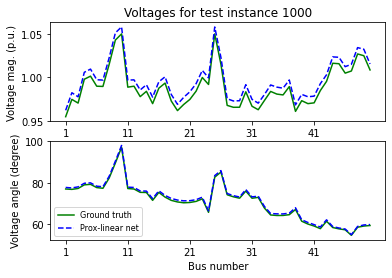

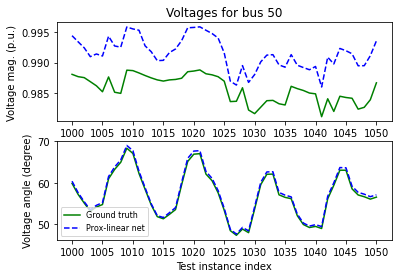

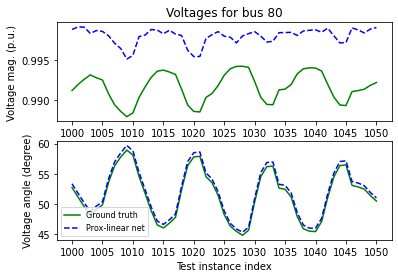

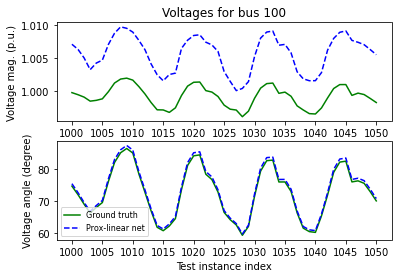

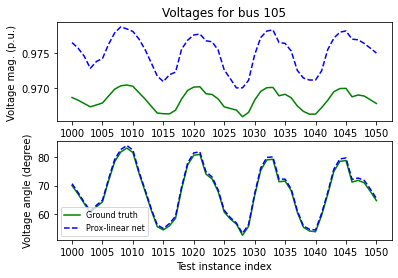

In [ ]:
# data loading part
psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
matlab_predicts = scipy.io.loadmat('/content/drive/My Drive/power_system/118_bus_GStest_err.mat')
gs_predicts = matlab_predicts['GS_voltage']
gs_predicts = np.transpose(gs_predicts)
print(gs_predicts.shape)
data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]
# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape)
print(val_x.shape)

#Train the model
input_shape = (train_x.shape[1],)

start_time = time.time()
lav_weights = '/content/drive/My Drive/power_system/nn1_psse.h5'


lav_model =   nn1_psse(input_shape, train_y.shape[1], weights=lav_weights)
# nn1_6H_model =  nn1_psse(input_shape, train_y.shape[1], weights=nn1_6H_weights)
# nn1_8H_model =  nn1_8H_psse(input_shape, train_y.shape[1], weights=nn1_8H_weights)

#train_lav_predicts = lav_model.predict(train_x)
lav_predicts = lav_model.predict(val_x)
# NN6H_predicts = nn1_6H_model.predict(val_x)
# NN8H_predicts = nn1_8H_model.predict(val_x)

print("--- %s seconds ---" % (time.time() - start_time))
val_predic = lav_predicts
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100

print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(lav_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN6H_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN8H_predicts, val_y))

fig_num = 0
plt.figure(fig_num)
fig_num += 1

busNo = caseNo
start_bus, end_bus = 0, 50
timeslot = 999
plt.subplot(2,1,1)
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* val_y[timeslot][start_bus: end_bus], color='g') # here we have start_bus+1 is due to that in our paper, index starts 1 while python starts 0
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* lav_predicts[timeslot][start_bus: end_bus], linestyle= '--',  color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN6H_predicts[timeslot][start_bus: end_bus],linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN8H_predicts[timeslot][start_bus: end_bus] , color='b')
linestyle= '-.'
plt.ylabel('Voltage mag. (p.u.)')
plt.title('Voltages for test instance ' + str(timeslot+1))
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))

plt.subplot(2,1,2)
plt.plot(range(start_bus+1, end_bus+1), val_y[timeslot][start_bus+ busNo: end_bus+ busNo], color='g')
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), lav_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '--', color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN6H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN8H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], color='b')
plt.ylabel('Voltage angle (degree)')
plt.xlabel('Bus number')
plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
# plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))


def plt_bus(busShow = 100, x_step = 5, start = 999, end = 1050, fig_num = 0):
    plt.figure(fig_num)
# this is for a certain bus across different time slots
    ax1 = plt.subplot(2,1,1)
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* val_y[start: end, busShow], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* lav_predicts[start: end, busShow], linestyle= '--',  color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN6H_predicts[start: end, busShow], linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN8H_predicts[start: end, busShow], color='b')
    #plt.hold
    #plt.plot(range(start+1, end+1), gs_predicts[start: end, busShow], color='c',linestyle= ':')

    ax1.set_xticks(list(range(start+1, end+1, x_step)))
    plt.ylabel('Voltage mag. (p.u.)')
    plt.title('Voltages for bus ' + str(busShow))

    plt.subplot(2,1,2)
    plt.plot(range(start+1, end+1), val_y[start: end, busShow + busNo], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), lav_predicts[start: end, busShow + busNo], linestyle= '--', color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), NN6H_predicts[start: end, busShow + busNo],  linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), NN8H_predicts[start: end, busShow + busNo], color='b')
    plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
    # plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})

    #plt.hold
    #plt.plot(range(start+1, end+1),  gs_predicts[start: end, busShow+ busNo], color='c',linestyle= ':')

    plt.ylabel('Voltage angle (degree)')
    plt.xlabel('Test instance index')
    axes = plt.gca()
    axes.set_xticks(list(range(start+1, end+1, x_step)))

bus_list = [50, 80, 100, 105]
for i, busShow in enumerate(bus_list):
    plt_bus(busShow = busShow, fig_num = i + 1)
plt.show()

**ANN_fase Plots and MaE value**

In [ ]:
tf.random.set_seed(SEED)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
#K.set_learning_phase(1)
#tf.compat.v1.Keras.backend.set_session(tf.compat.v1.Session(config=config))
K.set_learning_phase(1)

# data loading part
 


caseNo = 118
weight_4_mag = 100
weight_4_ang = 1#2*math.pi/360

psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
print(psse_data['inputs'].shape, psse_data['labels'].shape)

data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]


# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape, val_x.shape)
#Train the model
input_shape = (train_x.shape[1],)

epoch_num = 200
psse_model = ANN_fase(train_x.shape, train_y.shape[1])
psse_model.fit(train_x, train_y, epochs=epoch_num, batch_size=64)
psse_model.save_weights("/content/drive/My Drive/power_system/ANN_psse.h5")

# evaluate the model
K.set_learning_phase(0)
val_predic = psse_model.predict(val_x)
scores = psse_model.evaluate(val_x, val_y)
print("\n%s: %.2f%%" % (psse_model.metrics_names[1], scores[1]*100))


#the self.defined distance metric since, to access the distance between predicted and the true
print(val_y.shape[0])
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100
print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(val_predic, val_y))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(490, 18528) (236, 18528)
(14822, 490) (3706, 490)
Epoch 1/200
232/232 [==============================] - 1s 3ms/step - loss: 12.7850 - mae: 12.7850
Epoch 2/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1334 - mae: 1.1334
Epoch 3/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1224 - mae: 1.1224
Epoch 4/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1938 - mae: 1.1938
Epoch 5/200
232/232 [==============================] - 1s 3ms/step - loss: 1.2303 - mae: 1.2303
Epoch 6/200
232/232 [==============================] - 1s 3ms/step - loss: 1.2173 - mae: 1.2173
Epoch 7/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1939 - mae: 1.1939
Epoch 8/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1839 - mae: 1.1839
Epoch 9/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1390 - mae: 1.1390
Epoch 10/200
232/232 [==============================] - 1s 3ms/step - loss: 1.1217 

(3706, 236)
(14822, 490)
(3706, 490)
--- 1.1764471530914307 seconds ---

 distance from the true states in terms of \|\|_2: 0.0701%


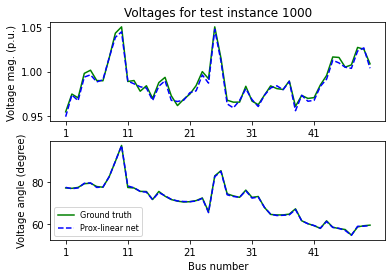

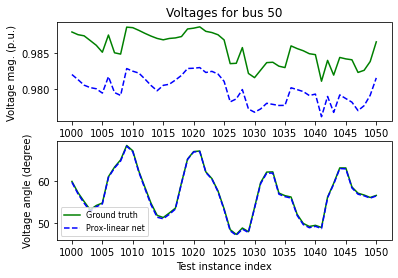

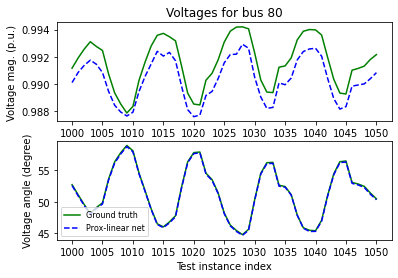

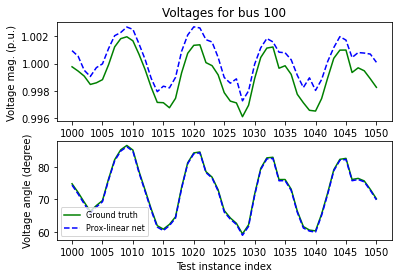

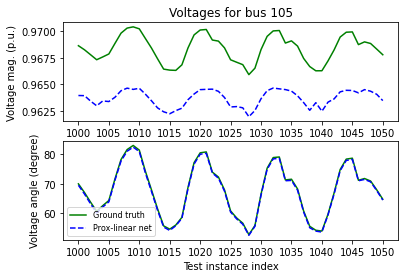

In [ ]:
# data loading part
psse_data = scipy.io.loadmat('/content/drive/My Drive/power_system/dist2_118FASE_data.mat')
matlab_predicts = scipy.io.loadmat('/content/drive/My Drive/power_system/118_bus_GStest_err.mat')
gs_predicts = matlab_predicts['GS_voltage']
gs_predicts = np.transpose(gs_predicts)
print(gs_predicts.shape)
data_x = psse_data['inputs']
data_y = psse_data['labels']

# scale the mags,
data_y[0:caseNo,:] = weight_4_mag*data_y[0:caseNo,:]
data_y[caseNo:,:] = weight_4_ang*data_y[caseNo:,:]
# seperate them into training 80%, test 20%
split_train = int(0.8*psse_data['inputs'].shape[1])
split_val = psse_data['inputs'].shape[1] - split_train #int(0.25*psse_data['inputs'].shape[1])
train_x = np.transpose(data_x[:, :split_train])
train_y = np.transpose(data_y[:, :split_train])
val_x   = np.transpose(data_x[:, split_train:split_train+split_val])
val_y   = np.transpose(data_y[:, split_train:split_train+split_val])
test_x  = np.transpose(data_x[:, split_train+split_val:])
test_y  = np.transpose(data_y[:, split_train+split_val:])

print(train_x.shape)
print(val_x.shape)

#Train the model
input_shape = (train_x.shape[1],)

start_time = time.time()
lav_weights = '/content/drive/My Drive/power_system/ANN_psse.h5'
#psse_model.save_weights("/content/drive/My Drive/power_system/ANN_psse.h5")


lav_model =   ANN_fase(train_x.shape, train_y.shape[1], weights=lav_weights)
# nn1_6H_model =  nn1_psse(input_shape, train_y.shape[1], weights=nn1_6H_weights)
# nn1_8H_model =  nn1_8H_psse(input_shape, train_y.shape[1], weights=nn1_8H_weights)

#train_lav_predicts = lav_model.predict(train_x)
lav_predicts = lav_model.predict(val_x)
# NN6H_predicts = nn1_6H_model.predict(val_x)
# NN8H_predicts = nn1_8H_model.predict(val_x)

print("--- %s seconds ---" % (time.time() - start_time))
val_predic = lav_predicts
test_no = 3706
def rmse(val_predic, val_y, voltage_distance = np.zeros((test_no,caseNo)), voltage_norm = np.zeros((test_no,1))):
    for i in range(test_no):
        for j in range(caseNo):
            predic_r, predic_i = (1/weight_4_mag)* val_predic[i, j]*math.cos(val_predic[i, j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_predic[i,j]*math.sin(val_predic[i, j+caseNo]*2*math.pi/360)
            val_r, val_i = (1/weight_4_mag)*val_y[i,j]*math.cos(val_y[i,j+caseNo]*2*math.pi/360), (1/weight_4_mag)*val_y[i][j]*math.sin(val_y[i][j+caseNo]*2*math.pi/360)
            voltage_distance[i,j] = (predic_r-val_r)**2 + (predic_i-val_i)**2
            #print(i, j, val_predic[i, j], val_predic[i, j+caseNo], val_y[i,j], val_y[i,j+caseNo])
        voltage_norm[i,] = (1/caseNo)*np.sqrt(np.sum(voltage_distance[i,:]))
    return np.mean(voltage_norm) *100

print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(lav_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN6H_predicts, val_y))
# print("\n distance from the true states in terms of \|\|_2: %.4f%%" % rmse(NN8H_predicts, val_y))

fig_num = 0
plt.figure(fig_num)
fig_num += 1

busNo = caseNo
start_bus, end_bus = 0, 50
timeslot = 999
plt.subplot(2,1,1)
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* val_y[timeslot][start_bus: end_bus], color='g') # here we have start_bus+1 is due to that in our paper, index starts 1 while python starts 0
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* lav_predicts[timeslot][start_bus: end_bus], linestyle= '--',  color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN6H_predicts[timeslot][start_bus: end_bus],linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), (1/weight_4_mag)* NN8H_predicts[timeslot][start_bus: end_bus] , color='b')
linestyle= '-.'
plt.ylabel('Voltage mag. (p.u.)')
plt.title('Voltages for test instance ' + str(timeslot+1))
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))

plt.subplot(2,1,2)
plt.plot(range(start_bus+1, end_bus+1), val_y[timeslot][start_bus+ busNo: end_bus+ busNo], color='g')
# plt.hold
plt.plot(range(start_bus+1, end_bus+1), lav_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '--', color='b')
# plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN6H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], linestyle= '-.', color='y')
# # plt.hold
# plt.plot(range(start_bus+1, end_bus+1), NN8H_predicts[timeslot][start_bus+ busNo: end_bus+ busNo], color='b')
plt.ylabel('Voltage angle (degree)')
plt.xlabel('Bus number')
plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
# plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})
axes = plt.gca()
axes.set_xticks(list(range(start_bus+1, end_bus+1, 10)))


def plt_bus(busShow = 100, x_step = 5, start = 999, end = 1050, fig_num = 0):
    plt.figure(fig_num)
# this is for a certain bus across different time slots
    ax1 = plt.subplot(2,1,1)
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* val_y[start: end, busShow], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), (1/weight_4_mag)* lav_predicts[start: end, busShow], linestyle= '--',  color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN6H_predicts[start: end, busShow], linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), (1/weight_4_mag)* NN8H_predicts[start: end, busShow], color='b')
    #plt.hold
    #plt.plot(range(start+1, end+1), gs_predicts[start: end, busShow], color='c',linestyle= ':')

    ax1.set_xticks(list(range(start+1, end+1, x_step)))
    plt.ylabel('Voltage mag. (p.u.)')
    plt.title('Voltages for bus ' + str(busShow))

    plt.subplot(2,1,2)
    plt.plot(range(start+1, end+1), val_y[start: end, busShow + busNo], color='g')
    # plt.hold
    plt.plot(range(start+1, end+1), lav_predicts[start: end, busShow + busNo], linestyle= '--', color='b')
    # plt.hold
    # plt.plot(range(start+1, end+1), NN6H_predicts[start: end, busShow + busNo],  linestyle= '-.', color='y')
    # # plt.hold
    # plt.plot(range(start+1, end+1), NN8H_predicts[start: end, busShow + busNo], color='b')
    plt.legend( ['Ground truth', 'Prox-linear net'], loc=3, prop={'size': 8})
    # plt.legend( ['Ground truth', 'Prox-linear net', '6-layer FNN', '8-layer FNN'], loc=3, prop={'size': 8})

    #plt.hold
    #plt.plot(range(start+1, end+1),  gs_predicts[start: end, busShow+ busNo], color='c',linestyle= ':')

    plt.ylabel('Voltage angle (degree)')
    plt.xlabel('Test instance index')
    axes = plt.gca()
    axes.set_xticks(list(range(start+1, end+1, x_step)))

bus_list = [50, 80, 100, 105]
for i, busShow in enumerate(bus_list):
    plt_bus(busShow = busShow, fig_num = i + 1)
plt.show()